# Superstore API
Time series predictions for the Superstore dataset.

## Goal
Predict sales amount for a given time frame.

# Model Selection
This notebook covers the predictive model selection.

## Imports
This notebook requires the following packages. Make sure you have them installed in order to use this notebook.

In [1]:
import datetime
import os

import numpy as np
import pandas as pd
import statsmodels as sm

## Default variables
Define default variables for the notebook.

In [2]:
ROOT_FOLDER = os.path.split(os.getcwd()[:-1])[0]
PROCESSED_DATA_FOLDER = os.path.join(ROOT_FOLDER, "data", "processed")
MODEL_FOLDER = os.path.join(ROOT_FOLDER, "model")

## Load data
The dataset is in the `data\processed` folder.

In [3]:
DATASET_FILE_NAME = "dataset.csv"

# Load.
data = pd.read_csv(
    os.path.join(PROCESSED_DATA_FOLDER, DATASET_FILE_NAME), 
    index_col="Order Date",
    parse_dates=["Order Date"],
    )["Sales"]
print(f"Number of rows = {data.shape[0]}")

# Set frequency as daily.
data.index.freq = 'D' 

data.head()

Number of rows = 1458


Order Date
2014-01-03      16.448
2014-01-04     288.060
2014-01-05      19.536
2014-01-06    4407.100
2014-01-07      87.158
Freq: D, Name: Sales, dtype: float64

Check visually.

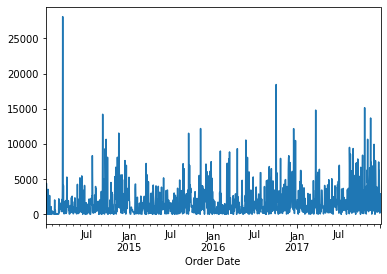

In [4]:
data.plot();

## Rolling Mean
We'll use rolling mean to smooth our data.

In [5]:
# data = data.rolling(7).mean().dropna()
# data.plot()

## Aggregate

In [6]:
# data = data.resample("M").sum()
# data.plot()
# data.head()

## Differencing

In [7]:
# data = data.diff(1).dropna()
# data.plot()

## Split Data

In [8]:
YEAR_DELTA = datetime.timedelta(days=365)
split_point = data.index.max() - YEAR_DELTA

train = data[data.index <= split_point]
test = data[data.index > split_point]

train.tail()

Order Date
2016-12-26    1829.418
2016-12-27     959.490
2016-12-28     959.490
2016-12-29    1277.680
2016-12-30     773.774
Freq: D, Name: Sales, dtype: float64

## Stationary

In [9]:
from statsmodels.tsa.stattools import adfuller

labels = ['ADF Test Statistic', 'P-Value','Number of Lags Used','Number of Observations Used']
results = adfuller(train)

results = pd.DataFrame({label: result for label, result in zip(labels, results)}, index=["Results"])

if results["P-Value"][0] <= 0.05:
    print("Strong evidence against the null hypothesis (Ho), reject the null hypothesis. Data has no unit root and is stationary.")
else:
    print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary.")

results.transpose()

Strong evidence against the null hypothesis (Ho), reject the null hypothesis. Data has no unit root and is stationary.


,Results
ADF Test Statistic,-9.251938e+00
P-Value,1.484174e-15
Number of Lags Used,6.000000e+00
Number of Observations Used,1.086000e+03


## Autocorrelation

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

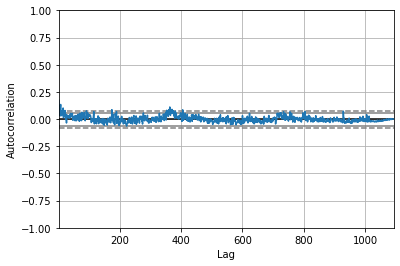

In [10]:
pd.plotting.autocorrelation_plot(train)

## ACF & PACF

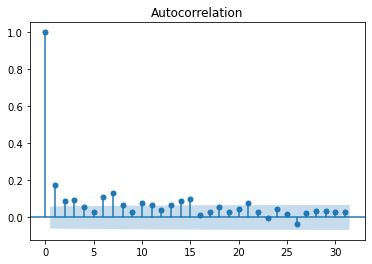

In [11]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(train);

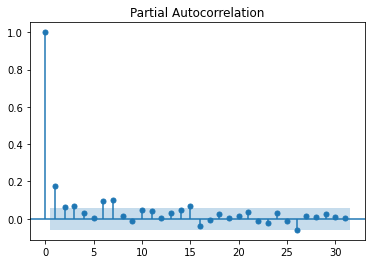

In [12]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(train);

## Modelling
Over the next cells we will check different models on our data.

In [13]:
def score(true, pred):
    """ Calculate root mean squared error and plot. """
    # Avoid inplace changes.
    true = true.copy()
    pred = pred.copy()

    # Change names.
    true.name = "True"
    pred.name = "Pred"

    # Plot.
    true.plot(legend=True)
    pred.plot(legend=True)
    
    # Calculate metric.
    return np.mean(np.sqrt(np.square(true - pred)))


def fit_predict_score(model, test, *args, **kwargs):
    """ Fit, predict and score model. """
    model = model.fit(*args, **kwargs)
    pred = model.predict(start=test.index.min(), end=test.index.max())
    return score(true=test, pred=pred)

### Mean

1599.3518085352616

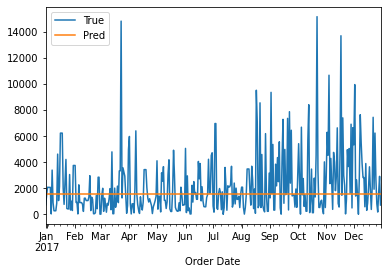

In [14]:
pred = pd.Series(train.mean(), index=test.index)
score(true=test, pred=pred)

### Autoregression (AR)

CPU times: user 5.83 s, sys: 5.22 s, total: 11.1 s
Wall time: 3.3 s


2607.246634130756

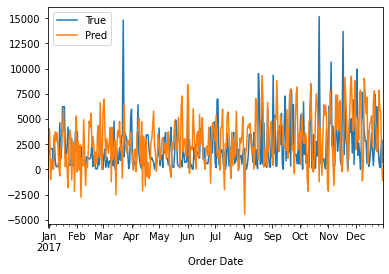

In [15]:
%%time

from statsmodels.tsa.ar_model import AutoReg

model = AutoReg(train, lags=365, old_names=False)
fit_predict_score(model, test)

### Autoregressive Integrated Moving Average (ARIMA)

In [16]:
# %%time

# from statsmodels.tsa.arima.model import ARIMA

# model = ARIMA(train, order=(7, 1, 365))
# fit_predict_score(model, test)

### Prophet
Data preparation.

In [17]:
def to_prophet(dataframe):
    """ Convert dataset to prophet. """ 
    dataframe = pd.DataFrame(dataframe)
    dataframe = dataframe.reset_index()
    dataframe = dataframe.rename(columns={"Order Date": "ds", "Sales": "y"})
    return dataframe


train = to_prophet(train)
train.head()

,ds,y
0,2014-01-03,16.448
1,2014-01-04,288.060
2,2014-01-05,19.536
3,2014-01-06,4407.100
4,2014-01-07,87.158


Fit and score.

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
CPU times: user 1min 33s, sys: 1min 6s, total: 2min 39s
Wall time: 43.8 s


1606.4088352056224

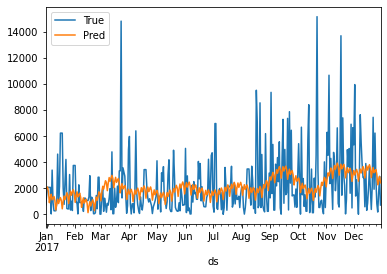

In [18]:
%%time

from prophet import Prophet

model = Prophet()
model.fit(train)

future = model.make_future_dataframe(periods=365)
model.predict(future)
forecast = model.predict(future)

pred = forecast.iloc[-365:].set_index("ds")["yhat"]
score(true=test, pred=pred)

## Save Model

In [19]:
import json
from prophet.serialize import model_to_json

# Train model on entire dataset.

data = to_prophet(data)
model = Prophet()
model.fit(data)

with open(os.path.join(MODEL_FOLDER, "model.json"), "w") as file:
    json.dump(model_to_json(model), file)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
